In [2]:
# This notebook shows how to interact directly with raw memory on device using pycuda
# usefull fo GPU accelerated libraries that do not support dlpack interface (e.g OpenGL)

In [3]:
from PIL import Image
from IPython.display import display

import python_vali as vali
import numpy as np

In [4]:
url = "../tests/data/test.mp4"

In [5]:
try:
    import pycuda
    import pycuda.autoinit
except:
    print("Pycuda is required to run this test")

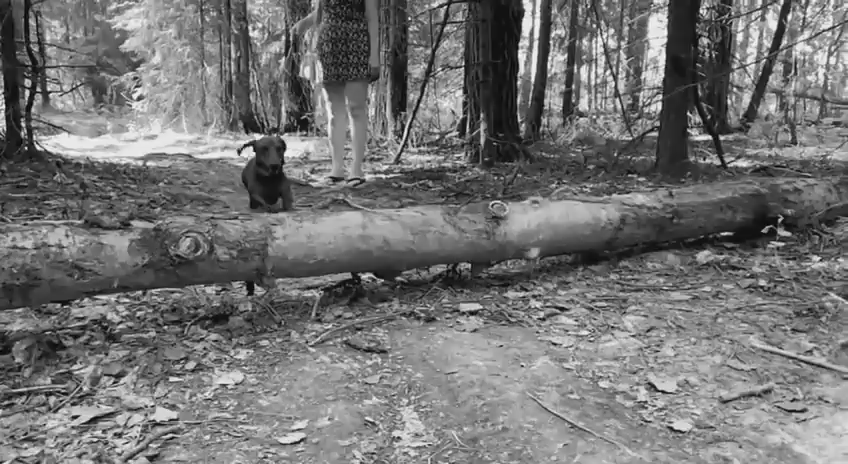

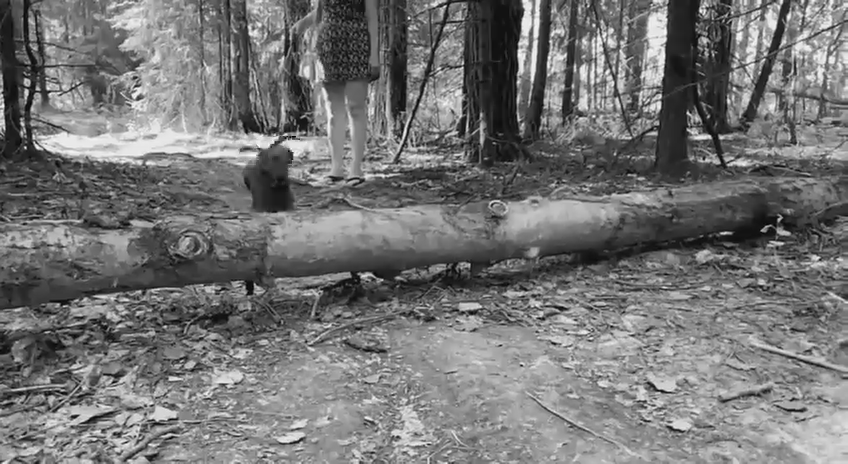

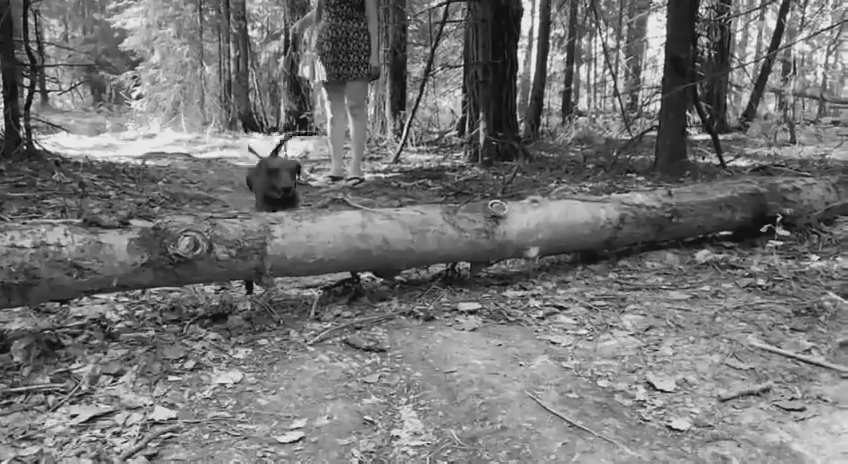

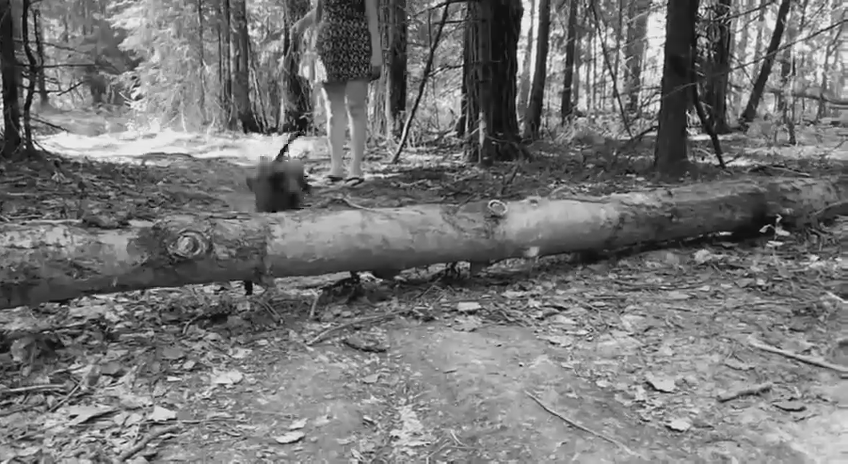

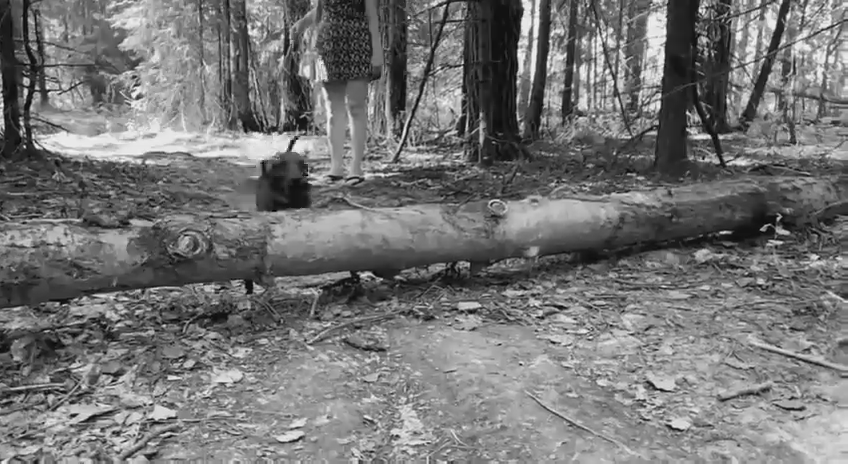

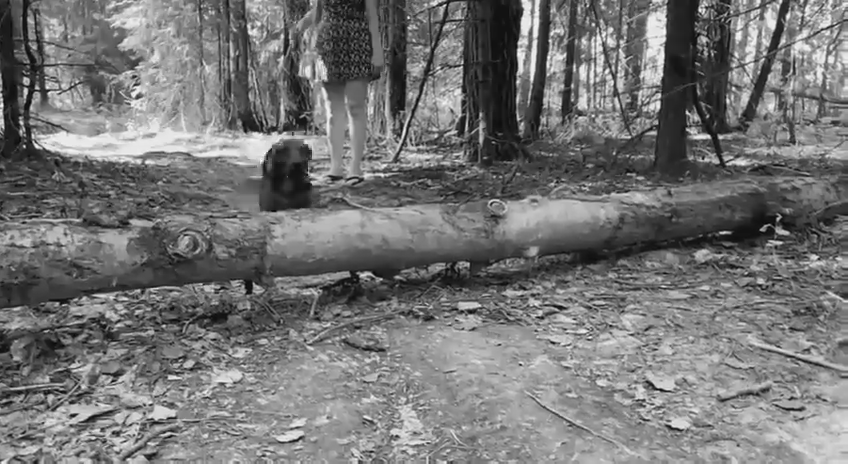

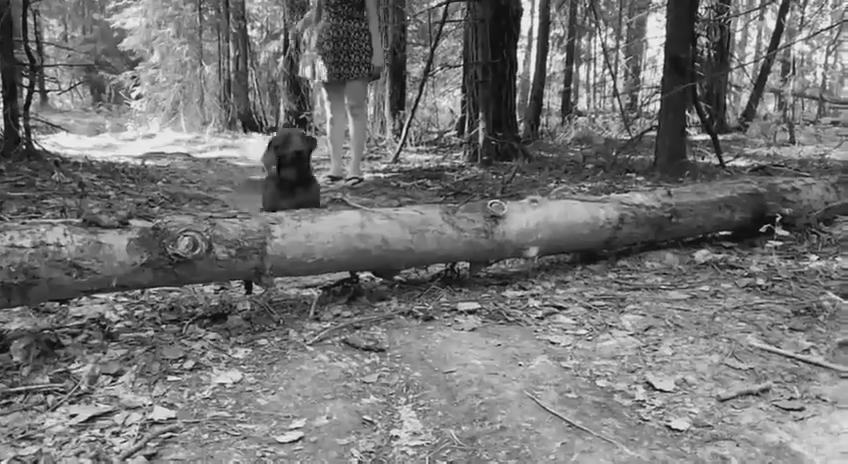

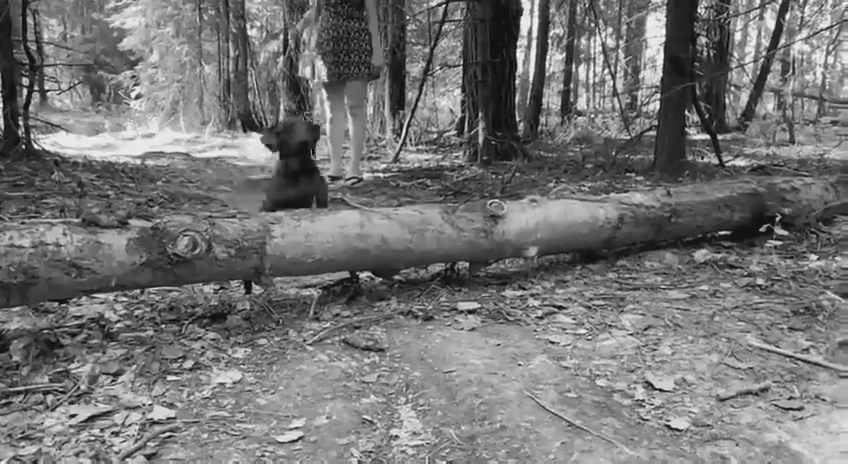

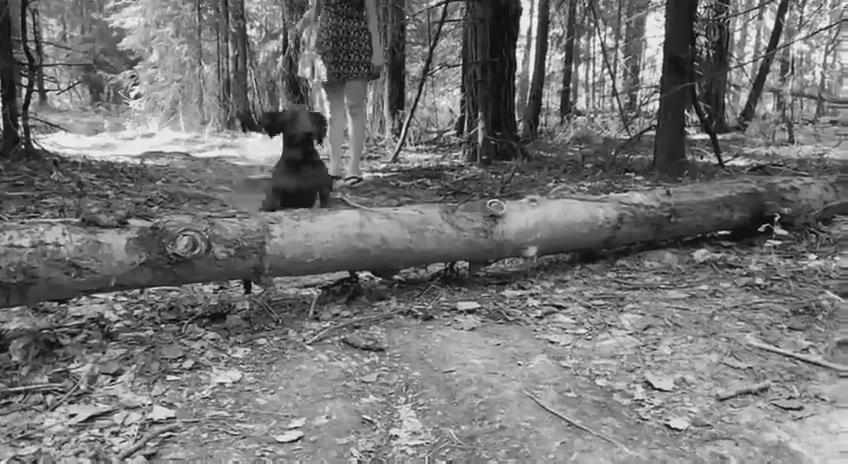

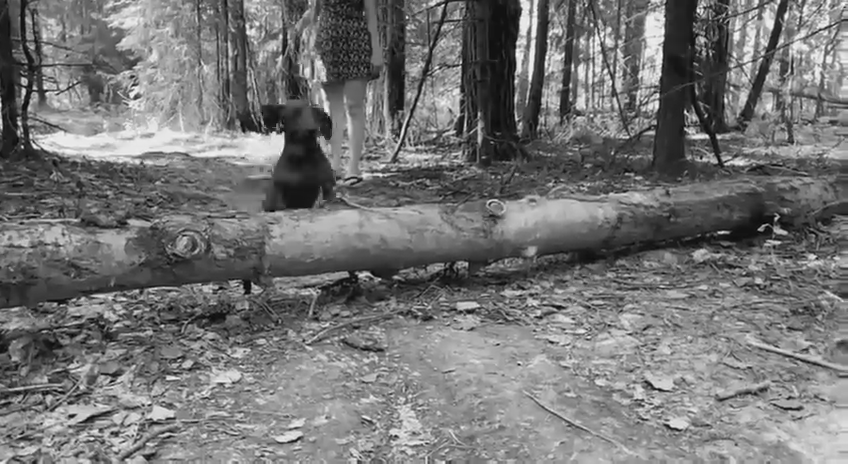

In [10]:
# download and display luma plane from nv12 decoded video frame
# GPU-accelerated decoder
pyDec = vali.PyDecoder(
    url,
    {},
    gpu_id=0)

# Example assumes pixel format is NV12
assert(pyDec.Format==vali.PixelFormat.NV12)

# Raw Surface, NV12 format
surf_src = vali.Surface.Make(
    format=pyDec.Format,
    width=pyDec.Width,
    height=pyDec.Height,
    gpu_id=0)

# Numpy buffer for collecting Y part of NV12 surface
y_buffer=np.ndarray(dtype=np.uint8,shape=pyDec.Width*pyDec.Height)

for _ in range (10):
    success, details = pyDec.DecodeSingleSurface(surf_src)
    if success:
        #download only luma plane and display it in notebook
        device_to_host=pycuda.driver.Memcpy2D()
        device_to_host.set_src_device(surf_src.Planes[0].GpuMem)
        device_to_host.set_dst_host(y_buffer)
        device_to_host.width_in_bytes = surf_src.Planes[0].Width
        device_to_host.src_pitch = surf_src.Planes[0].Pitch
        device_to_host.dst_pitch = surf_src.Planes[0].Width
        device_to_host.src_height = surf_src.Planes[0].Height*2//3 ## luma plane is 2/3 of nv12 image. could use surf_src.Height()
        device_to_host.height = surf_src.Planes[0].Height*2//3
        device_to_host(aligned=True)
        
        y_plane = np.reshape( y_buffer,(pyDec.Height, pyDec.Width))
        # Display in notebook
        display(Image.fromarray(y_plane,mode="L"))

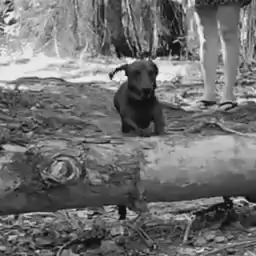

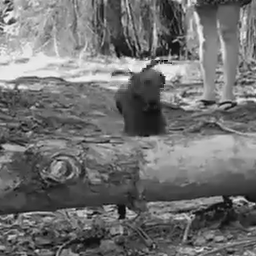

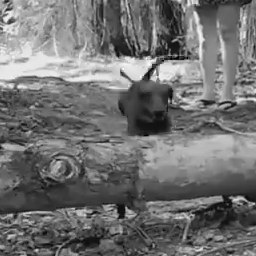

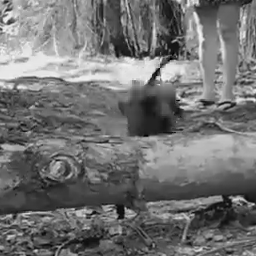

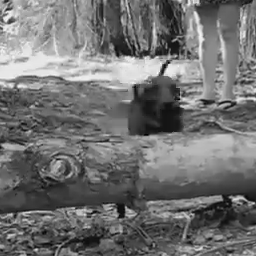

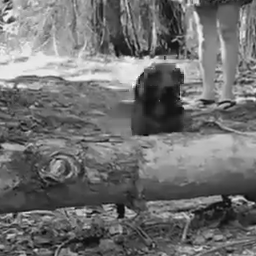

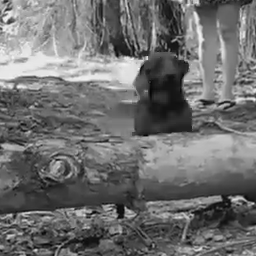

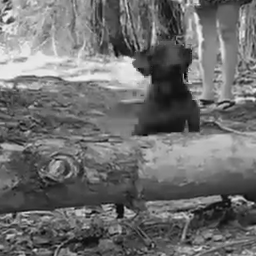

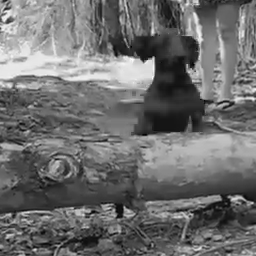

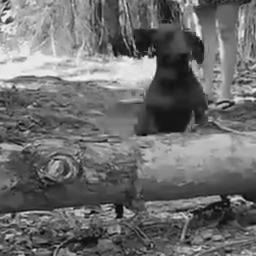

In [11]:
# more advanced example, with hardware cropping
# GPU-accelerated decoder
pyDec = vali.PyDecoder(
    url,
    {},
    gpu_id=0)

# Example assumes pixel format is NV12
assert(pyDec.Format==vali.PixelFormat.NV12)

# Raw Surface, NV12 format
surf_src = vali.Surface.Make(
    format=pyDec.Format,
    width=pyDec.Width,
    height=pyDec.Height,
    gpu_id=0)

# Numpy buffer for collecting cropped Y part of NV12 surface
w=256
h=256
top=76
left=128
y_buffer=np.ndarray(dtype=np.uint8,shape=w*h)

for _ in range (10):
    success, details = pyDec.DecodeSingleSurface(surf_src)
    if success:
        #download cropped luma plane and display it in notebook
        device_to_host=pycuda.driver.Memcpy2D()
        device_to_host.set_src_device(surf_src.Planes[0].GpuMem+
                                      top*surf_src.Planes[0].Pitch+
                                      left)
        device_to_host.set_dst_host(y_buffer)
        device_to_host.width_in_bytes = w
        device_to_host.src_pitch = surf_src.Planes[0].Pitch
        device_to_host.dst_pitch = w
        device_to_host.src_height = h
        device_to_host.height = h
        device_to_host(aligned=True)
        
        y_plane = np.reshape( y_buffer,(w,h))
        # Display in notebook
        display(Image.fromarray(y_plane,mode="L"))